# Reinforcement Learning

Today's topic, Reinforcement Learning, is closed to what you might have traditionally meant by "artificial intelligence," which maybe isn't a word that you would necessarily apply to a CNN that labels pictures of galaxies (though maybe you would.) When we thing of artificial intelligence, we think of a computer that can learn to play chess, or a robot that can learn to walk. Reinforcement learning is the field of machine learning that deals with these kinds of problems.

The essential ideas of RL are:
- an *agent* is exploring an *environment.*
- at any given time, the agent perceives a *state* of the environment, $s\in S$.
- the agent can take *actions* that change the state of the environment, $a\in A$.
- but how does the agent choose? via a *policy function* $\pi:S\rightarrow A$. The policy might be deterministic, or it might be stochastic, an $s$-dependent probability density on $A$.
- by following the policy, the agent generates a trajectory through state space, that terminates either at some fixed timeout or when the agent reaches a *terminal state,* characterized by an end goal like checkmate.
- at each time step, the agent receives a *reward* $r_t$ that depends on the state, which accumulate into a *return*
    $$G_t = \sum_{k=0}^\infty \gamma^k r_{t+k+1}$$
    where $\gamma\in[0,1]$ is a *discount factor* that determines how much the agent cares about the future.
- the expected return given a state is the *value function* a.k.a. *state value function* of a state, 
        $$v_\pi(s) = \mathbb{E}_\pi[G_t|S_t=s],$$
  and the expected return given a state-action pair is the *action value function*,
        $$q_\pi(s,a) = \mathbb{E}_\pi[G_t|S_t=s,A_t=a].$$

The goal of RL is to find a policy that maximizes the expected return. Some algorithms do this by estimating the value function or action-value function, and then using it to find the optimal policy. These are called *value-based* algorithms. Others directly estimate the optimal policy. These are called *policy-based* methods, or policy gradients.

As a litmus test for whether RL is right for your problem, you should ask whether it naturally admits a description in terms of an agent exploring an environment, and taking particular actions to do so. Also necessary is a notion of what is "good" or "bad" in the environment, to set up your reward. If the state space is small enough, the problem can be solved by going through all the states brute-force. However, in cases with exponentially large state spaces, such as Chess or Go or String Theory, we can't go through all the states and instead use techniques that approximate the value function or policy. In practice, those techniques are neural networks, and the associated RL techniques are called *deep reinforcement learning.*

For more on RL, see:
- [Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html), a famous early textbook.
- [David Silver's course](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html), a more modern take. The videos were my entry point into RL.
- [AlphaZero](https://www.nature.com/articles/nature24270), a 2017 breakthrough in which RL achieves superhuman gameplay in Go *without human knowledge*, i.e. only via knowledge of the game and self-play. It was extended to Chess and Shogi in 2018. See the arXiv article here: [Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm](https://arxiv.org/abs/1712.01815).
- My friends and I introduced RL into string theory in [Branes with Brains](https://arxiv.org/abs/1903.11616). We have also used it to [find unknots](https://arxiv.org/abs/2010.16263) and [ribbons](https://arxiv.org/abs/2304.09304), the latter in connection with the smooth 4d Poincaré conjecture.


# Gridworld

In this class we'll study a famous game in RL called *Gridworld*, see. e.g. Sutton and Barto for more. It's a simple game that is easy to understand, but still has some interesting features. The game is played on a grid, and the agent can move up, down, left, or right. The agent starts in a random position, and the goal is to reach the goal state, which is chosen via the policy.
The game ends when the agent reaches the goal.

### Defining Gridworld
This module defines the Gridworld game environment.

In [15]:
# The gridworld environment
# Original code downloaded from https://gist.github.com/kfeeeeee/e81aeeff0516cfd7645c8e99cd4fa315#file-gridworld-py
# Modifications made by Fabian Ruehle
# Note that I completely change the game (rules, rewards, goal, colors)

%matplotlib inline
import numpy as np
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(4)


# This represents an object in the game: worker, pitfall, exit
class GameOb:
    def __init__(self, name, reward, coordinates, size, RGBA):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.channel = RGBA
        self.reward = reward
        self.name = name


# The gridworld environment
class GameEnv:
    def __init__(self):
        # initialization of the world
        self.sizeX = 9
        self.sizeY = 9
        self.num_pits = 7
        self.state = ()  # A state in gridworld is just the (x,y) coordinate pair of the worker
        self.objects = []
        self.initial_x = 0
        self.initial_y = 0
        self.gave_up = False
        self.fell = False

        # We want the worker to solve the maze as fast as possible without falling into the pits:
        # *)   -1 for each step (penalty to solve it quickly)
        # *)  -50 for each pitfall (penalty for falling into the pit)
        # *) +100 for finding the exit (reward for solving the maze)
        # *)   -2 for running into a wall / not moving at all
        self.step_penalty = -1.
        self.pitfall_penalty = -50.
        self.exit_reward = 100.
        self.no_move_penalty = -2.

        # Actions in gridworld: move up, down, left, right
        self.action_space = [0, 1, 2, 3]  # up, down, left, right

        # keep track of the total number of steps and the steps that were taken in the game
        self.steps = 0
        self.steps_taken = []

        # maximal n umber of steps before we give up solving the maze
        self.max_steps = 1000

        # plotting the maze
        plt.ioff()  # there is currently a bug for Mac users which requires turning this off
        self.world_canvas = plt.figure("Maze")
        self.world_canvas.suptitle('Blue: Worker, Red: Pitfalls, Green: Exit')
        self.im = None
        plt.axis("off")

        # initialize and plot the world
        self.world = self.initialize_world()
        self.snapshot_world = self.initialize_world()

    # initialize a new random world
    def initialize_world(self):
        self.objects = []

        # 1.) The first parameter is the name of the object
        # 2.) The second parameter is the reward / penalty:
        # 3.) The third parameter is the position of the object in the world
        # 4.) Ignore the other parameters, they are just used for drawing the world (box sizes and color)

        # fix position of exit and worker
        # maze_exit = GameOb('exit', self.exit_reward, self.new_position(), 1, [0, 1, 0, 1])
        maze_exit = GameOb('exit', self.exit_reward, [4, 4], 1, [0, 1, 0, 1])
        self.objects.append(maze_exit)
        # worker = GameOb('worker', None, self.new_position(), 1, [0, 0, 1, 1])
        worker = GameOb('worker', None, [0, 0], 1, [0, 0, 1, 1])
        self.objects.append(worker)
        for i in range(self.num_pits):  # add pitfalls
            pitfall = GameOb('pitfall', self.pitfall_penalty, self.new_position(), 1, [1, 0, 0, 1])
            self.objects.append(pitfall)

        # store the initial (x,y) coordinates for a reset
        self.initial_x = worker.x
        self.initial_y = worker.y

        # show the world
        world = self.render_world()

        # initialize/ reset the variables
        self.reset()

        # plot the world
        plt.ioff()
        self.im = plt.imshow(world, interpolation="nearest")

        return world

    # reset the world to its initial configuration, ignore this
    def reset(self):
        self.steps = 0
        self.steps_taken = []
        self.gave_up = False
        self.fell = False
        self.state = (self.initial_x, self.initial_y)
        # np.random.seed(random.randint(0, 100000))
        for obj in self.objects:
            if obj.name == 'worker':
                obj.x = self.initial_x
                obj.y = self.initial_y
                break

    # move through the world
    # 0 - up, 1 - down, 2 - left, 3 - right
    def move_worker(self, direction):

        # identify the worker amongst the gridworld objects
        worker = None
        others = []
        for obj in self.objects:
            if obj.name == 'worker':
                worker = obj
            else:
                others.append(obj)

        worker_x = worker.x
        worker_y = worker.y

        # overall reward/penalty
        reward = self.step_penalty  # penalize each move

        # update the position of the worker in gridworld (move if possible)
        if direction == 0 and worker.y >= 1:
            worker.y -= 1
        if direction == 1 and worker.y <= self.sizeY - 2:
            worker.y += 1
        if direction == 2 and worker.x >= 1:
            worker.x -= 1
        if direction == 3 and worker.x <= self.sizeX - 2:
            worker.x += 1

        # move was illegal
        if worker.x == worker_x and worker.y == worker_y:
            reward = self.no_move_penalty

        # update to new position
        for i in range(len(self.objects)):
            if self.objects[i].name == 'worker':
                self.objects[i] = worker
                break

        # check whether new field is a special field (exit/pitfall) and compute reward/penalty
        is_maze_solved = False
        for other in others:
            if worker.x == other.x and worker.y == other.y:  # the worker ran into an object
                if other.name == "exit":  # the object was an exit
                    is_maze_solved = True
                    # print "I found the exit,yay!"
                    reward = other.reward
                    break  # we can exit the loop here since we can only run into one object
                elif other.name == "pitfall":  # the object was a pitfall
                    is_maze_solved = False
                    reward = other.reward
                    self.fell = True
                    break   # we can exit the loop here since we can only run into one object

        return reward, is_maze_solved

    # perform the step, collect the reward, check whether you have reached the exit
    def step(self, action, update_view=True):

        # collect the reward/punishment for the field the worker ends up in and check whether the exit was reached
        reward, done = self.move_worker(action)

        self.steps += 1
        self.steps_taken.append(action)

        # give up
        if self.steps >= self.max_steps and not done:
            done = True
            self.gave_up = True

        # fell into pit
        if self.fell:
            done = True

        # this just updates the graphic output of the world
        if update_view:
            # world = self.render_world()
            # plt.imshow(world, interpolation="nearest")
            self.im.set_array(self.render_world())
            plt.draw()

        # return the new state, the penalty/reward for the move and whether gridworld is solved/given up on
        return self.get_state(), reward, done

    # get the current state
    def get_state(self):
        for obj in self.objects:
            if obj.name == 'worker':
                return obj.x, obj.y

    # check whether an action is possible, i.e. whether a wall is blocking the way
    def is_possible_action(self, action):
        is_possible = False
        if action == 0 and self.state[1] >= 1:
            is_possible = True
        if action == 1 and self.state[1] <= self.sizeY - 2:
            is_possible = True
        if action == 2 and self.state[0] >= 1:
            is_possible = True
        if action == 3 and self.state[0] <= self.sizeX - 2:
            is_possible = True

        return is_possible

    ####################################################################################################################
    # ignore the code from here on, it just draws the world and represents the objects in the game.                    #
    ####################################################################################################################
    def close_world_display(self):
        plt.close("Gridworld")

    def new_position(self):
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        current_position = []
        for objectA in self.objects:
            if (objectA.x, objectA.y) not in current_position:
                current_position.append((objectA.x, objectA.y))
        for pos in current_position:
            points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]

    def render_world(self):
        a = np.zeros([self.sizeY + 2, self.sizeX + 2, 4])
        a[0:, 0, 3] = 1  # left wall
        a[0, 0:, 3] = 1  # top wall
        a[0:, self.sizeX + 1, 3] = 1  # right wall
        a[self.sizeY + 1, 0:, 3] = 1  # bottom wall
        a[1:-1, 1:-1, :] = 1
        for item in self.objects:
            if a[item.y + 1, item.x + 1, 0] == 1 and a[item.y + 1, item.x + 1, 1] == 1 and a[item.y + 1, item.x + 1, 2] == 1:  # is completely white
                for i in range(len(item.channel)):
                    a[item.y + 1:item.y + item.size + 1, item.x + 1:item.x + item.size + 1, i] = item.channel[i]
            else:  # other object on the field, overlay worker with pitfalls / exit
                for i in range(len(item.channel)):
                    if a[item.y + 1, item.x + 1, i] == 0:
                        a[item.y + 1:item.y + item.size + 1, item.x + 1:item.x + item.size + 1, i] += item.channel[i]
        a = np.array(Image.fromarray(np.uint8(a * 255)).resize((84, 84), Image.NEAREST))
        return a
    def plot_world(self):
        im = plt.imshow(self.render_world())
        plt.gca().set_axis_off()
        plt.show()

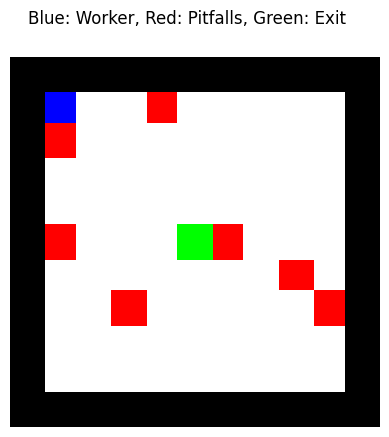

In [2]:
agent = GameEnv()
agent.plot_world()

((0, 1), -50.0, True)


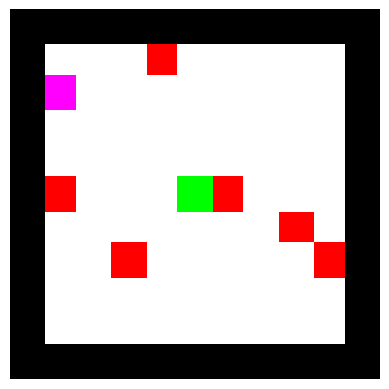

In [6]:
print(agent.step(1))  # down
agent.plot_world()

((1, 1), -1.0, True)


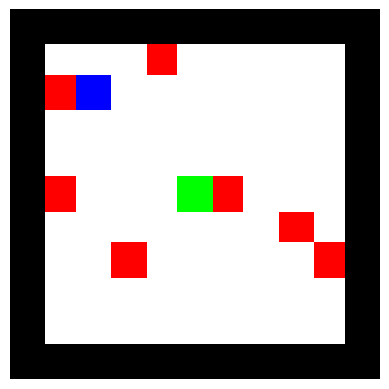

In [7]:
print(agent.step(3))  # right
agent.plot_world()

((1, 0), -1.0, True)


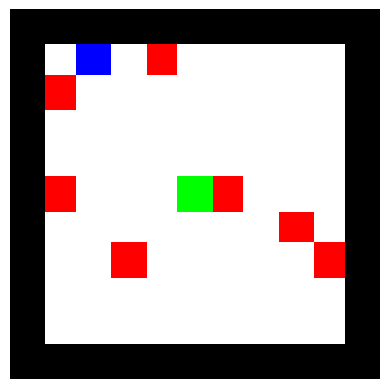

In [8]:
print(agent.step(0))  # up
agent.plot_world()

((0, 0), -1.0, True)


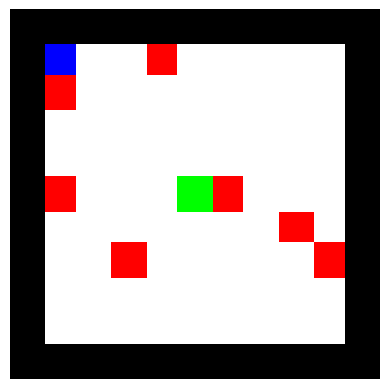

In [9]:
print(agent.step(2))  # left
agent.plot_world()

In [21]:
# Some helper functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# get the best action. If several actions are equally good, choose a random one
def get_best_action(dct):
    best_actions = []
    max_key = None
    max_val = float('-inf')
    for k, v in dct.items():
        if v > max_val:
            max_val = v
            max_key = k
            best_actions = [[max_key, max_val]]
        elif v == max_val:
            best_actions.append([k, v])

    return best_actions[np.random.randint(0, len(best_actions))]

# randomize the action in 100*eps percent of the cases
def random_action(action, action_space, eps=0.3):
    p = np.random.random()
    if p < (1 - eps):
        return action
    else:
        return np.random.choice(action_space)

# Animate the steps taken, ignore this
step_counter = 0
explore_step = None
def animate_steps(agent, window_title, fig_title=""):
    global step_counter
    plt.ioff()
    fig = plt.figure(window_title)
    fig.suptitle(fig_title)
    my_steps = agent.steps_taken
    agent.reset()
    step_counter = 0
    im = plt.imshow(agent.render_world(), animated=True)

    def update_fig(*args):
        global explore_step, step_counter
        if step_counter == 0:
            agent.reset()
        elif step_counter <= len(my_steps):
            explore_step = my_steps[step_counter-1]
            agent.step(explore_step, False)
        else:
            step_counter = -1
            agent.reset()
        im.set_array(agent.render_world())
        plt.draw()
        step_counter += 1
        return im

    plt.axis("off")
    ani = animation.FuncAnimation(fig, update_fig, interval=300, blit=False, frames=len(my_steps)+1, repeat=True)
    ani.save("./" + window_title + ".gif", writer=animation.PillowWriter(fps=5))
    agent.close_world_display()


Now we have the agent explore Gridworld. Since the state space is small, we can explore the entire environment and find optimal policies. We will do so using an algorithm called *SARSA*. The basic idea is to estimate the action-value function $q_\pi(s,a)$, and then use it to find the optimal policy. The algorithm is as follows:
- Initialize $Q(s,a)$ arbitrarily.
- 

In [22]:
########################################################################################################################
# Part 1: Play the game once to see an untrained agent at work
########################################################################################################################
agent.reset()
agent.close_world_display()
print("Let the game begin...")

# generate all states
all_states = []
for x in range(agent.sizeX):
    for y in range(agent.sizeY):
        all_states.append((x, y))

# Q is a dictionary that contains the rewards for all four actions that can be performed in any given square of Gridworld.
# Initialize Q and keep track of how many times Q[s] has been updated
Q = {}
update_counts_sa = {}
for s in all_states:
    update_counts_sa[s] = {}
    Q[s] = {}
    for a in agent.action_space:
        update_counts_sa[s][a] = 1.0
        Q[s][a] = 0.0

gamma = 0.9  # discount factor
alpha_W = 0.1  # learning rate
t = 1.0  # count time

########################################################################################################################

# To start the algorithm, we need any action, so we pick one randomly until we find a valid action which we perform
found_initial_move = False
current_action = None
current_state = agent.get_state()
while not found_initial_move:
    current_action = random_action(None, agent.action_space, eps=1)
    found_initial_move = agent.is_possible_action(current_action)

# loop until done (i.e. solved the maze or gave up)
done = False
while not done:
    # perform the current step and get the next state, the reward/penalty for the move, and whether the agent is done (solved or gave up)
    next_state, reward, done = agent.step(current_action, False)

    # get the best currently known action for the state we are in now
    next_action = get_best_action(Q[current_state])[0]
    # randomize the action to allow for exploration. As time progresses, make random actions less likely.
    next_action = random_action(next_action, agent.action_space, eps=0.4/t)

    # Update Q
    alpha = alpha_W / update_counts_sa[current_state][current_action]
    update_counts_sa[current_state][current_action] += 0.005
    Q[current_state][current_action] = Q[current_state][current_action] + alpha * (reward + gamma * Q[next_state][next_action] - Q[current_state][current_action])

    # update current state, current action, and start over
    current_state = next_state
    current_action = next_action
    t += 0.001

########################################################################################################################
# Part 2: Show the exploration route taken by the untrained worker
########################################################################################################################

# show exploration route
result = ""
if not agent.gave_up and reward > 0:
    result = "I solved gridworld in " + str(agent.steps) + " steps."
else:
    result = "Sorry, I had to give up after " + str(agent.max_steps) + " steps."
print(result)

# Animate the steps of the first game
animate_steps(agent, "Gridworld exploration untrained worker", result)

########################################################################################################################
# Part 3: Play the game 10,000 times to learn the best solution strategy
########################################################################################################################

print("Now let me train for a while, I enjoyed the game so much!")

agent.reset()
plt.close('all')

# The code is essentially identical to the one used above, but now carried out 10,000 times
training_episodes = 10000
for i in range(training_episodes):
    if i % 1000 == 0:
        print("I'm playing game " + str(i) + " / " + str(training_episodes))
    if i % 100 == 0:
        t += 0.01
    agent.reset()
    found_initial_move = False
    current_action = None
    current_state = agent.get_state()
    while not found_initial_move:
        current_action = random_action(None, agent.action_space, eps=1)
        found_initial_move = agent.is_possible_action(current_action)
    done = False

    # loop until done (i.e. solved the maze or gave up)
    while not done:
        # perform the current step and get the next state, the reward/penalty for the move, and whether the agent is done (solved or gave up)
        next_state, reward, done = agent.step(current_action, False)

        # get the best currently known action for the state we are in now
        next_action = get_best_action(Q[current_state])[0]
        # randomize the action to allow for exploration. As time progresses, make random actions less likely.
        next_action = random_action(next_action, agent.action_space, eps=0.4/t)

        # Update Q
        alpha = alpha_W / update_counts_sa[current_state][current_action]
        update_counts_sa[current_state][current_action] += 0.005
        Q[current_state][current_action] = Q[current_state][current_action] + alpha * (reward + gamma * Q[next_state][next_action] - Q[current_state][current_action])

        # update current state, current action, and start over
        current_state = next_state
        current_action = next_action

print("Ok, I am done practicing.")
agent.reset()
plt.close('all')

########################################################################################################################
# Part 4: Show the exploration route taken by the trained worker
########################################################################################################################

# Navigate the maze using the best steps as learned by the agent
current_state = agent.get_state()
done = False
while not done:
    current_action = get_best_action(Q[current_state])[0]
    current_state, reward, done = agent.step(current_action, False)

result = ""
if not agent.gave_up and reward > 0:
    result = "I can now solve Gridworld in " + str(agent.steps) + " steps."
else:
    result = "I haven't learned solving Gridworld in " + str(agent.max_steps) + " steps."
print(result)

# Animate the steps of the trained worker
animate_steps(agent, "Gridworld exploration trained worker", result)

print("Thanks for playing! Bye.")


Let the game begin...
Sorry, I had to give up after 1000 steps.
Now let me train for a while, I enjoyed the game so much!
I'm playing game 0 / 10000
I'm playing game 1000 / 10000
I'm playing game 2000 / 10000
I'm playing game 3000 / 10000
I'm playing game 4000 / 10000
I'm playing game 5000 / 10000
I'm playing game 6000 / 10000
I'm playing game 7000 / 10000
I'm playing game 8000 / 10000
I'm playing game 9000 / 10000
Ok, I am done practicing.
I can now solve Gridworld in 8 steps.
Thanks for playing! Bye.


In [23]:
q_value, update_count, direction = [[0 for _ in range(agent.sizeX)] for _ in range(agent.sizeY)], [[0 for _ in range(agent.sizeX)] for _ in range(agent.sizeY)], [[0 for _ in range(agent.sizeX)] for _ in range(agent.sizeY)]
for x in range(agent.sizeX):
    for y in range(agent.sizeY):
        q_value[x][y] = np.mean(list(Q[(x, y)].values()))
        update_count[x][y] = np.sum(list(update_counts_sa[(x, y)].values()))
        ba = [max(0, a) for a in Q[(x, y)].values()]
        dxy = (ba[3] - ba[2], ba[0] - ba[1])
        if sum(dxy) != 0:
            dxy = (dxy[0]/np.sqrt(dxy[0]*dxy[0]+dxy[1]*dxy[1]), dxy[1]/np.sqrt(dxy[0]*dxy[0]+dxy[1]*dxy[1]))
        direction[x][y] = dxy
# transpose
direction = np.einsum('xya->yxa', direction)


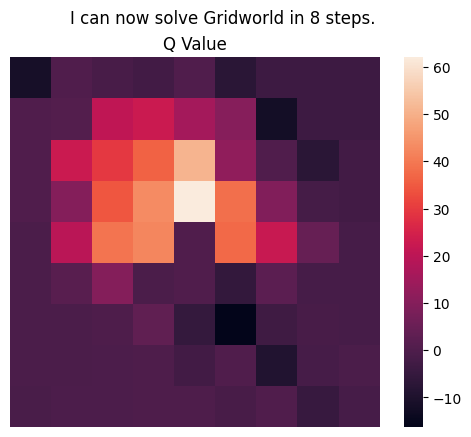

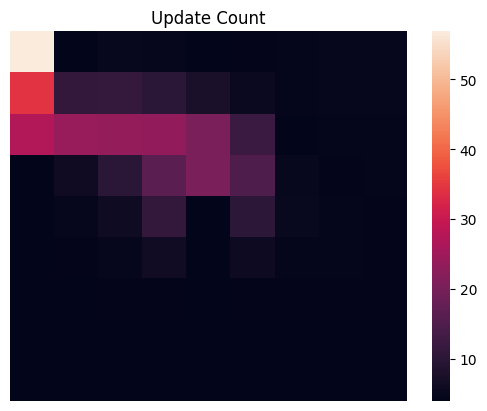

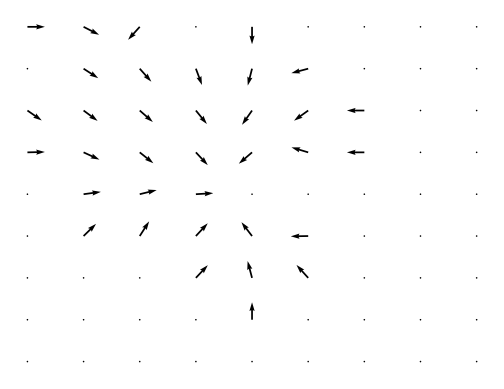

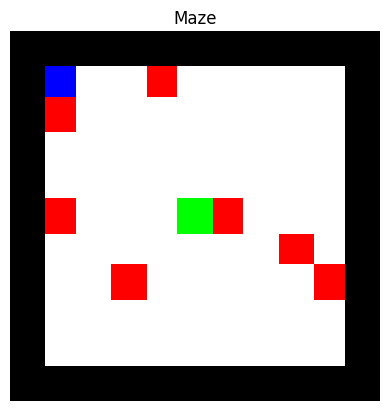

In [24]:
sns.heatmap(q_value)
plt.gca().set_axis_off()
plt.title("Q Value")
plt.show()

plt.title("Update Count")
sns.heatmap(update_count)
plt.gca().set_axis_off()
plt.show()

fig, axs = plt.subplots(agent.sizeY,agent.sizeY);
for ax, ds in zip (axs, direction):
    for a, uv in zip(ax, ds):
        a.quiver(0, 0, uv[0], uv[1], angles='xy', scale_units='xy', scale=1, width=.05)
        a.set_xlim(-1, 1)
        a.set_ylim(-1, 1)
        a.set_aspect('equal')
        a.set_axis_off()
plt.show()

plt.title("Maze")
agent.reset()
im = plt.imshow(agent.render_world())
plt.gca().set_axis_off()
plt.show()

In [25]:
import IPython.display as idp
idp.Image(url='./Gridworld exploration untrained worker.gif')

In [26]:
idp.Image(url='./Gridworld exploration trained worker.gif')

## Conclusion
This notebook demonstrates the integration and functionality of a Gridworld game environment using Python.